In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.display import display
import math
import matplotlib.pyplot as plt
from sklearn import metrics

## Gradient boosting explanation

In [3]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)
        
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [4]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

In [5]:
# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

In [6]:
x.shape, y.shape

((50, 1), (50L, 1L))

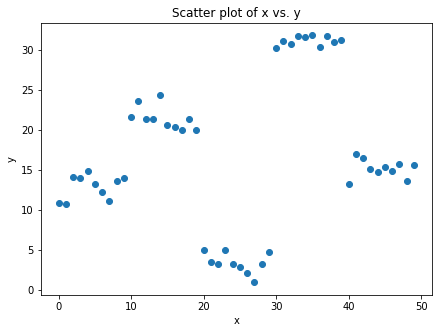

In [7]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

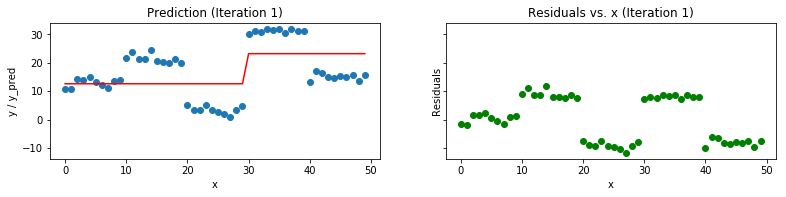

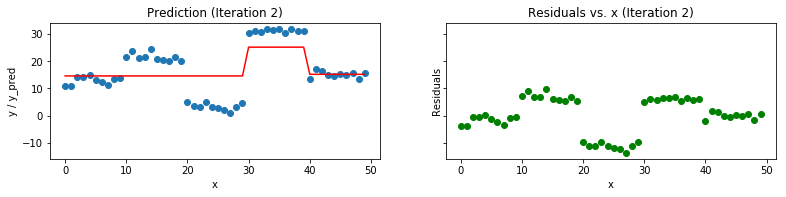

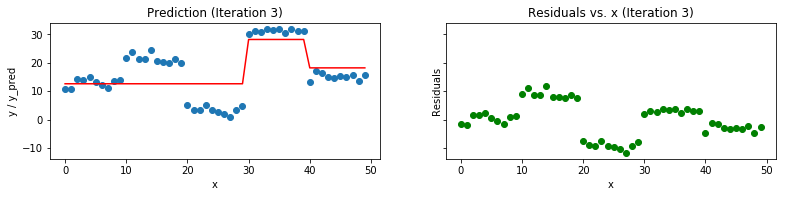

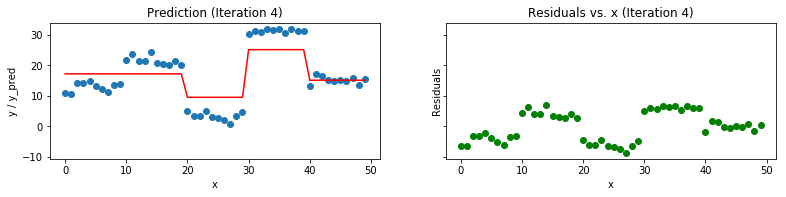

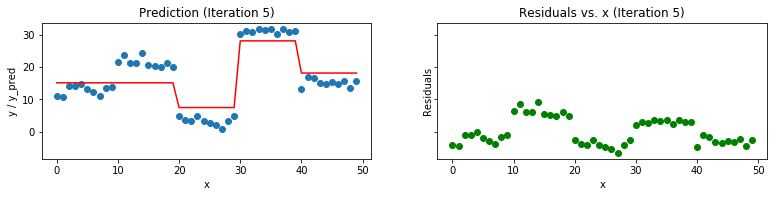

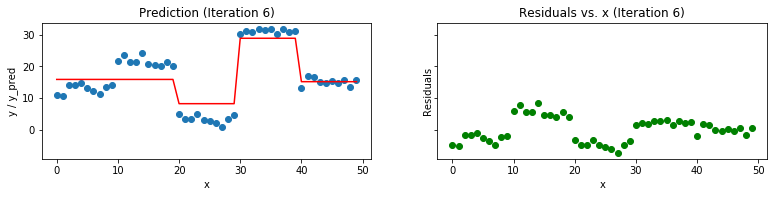

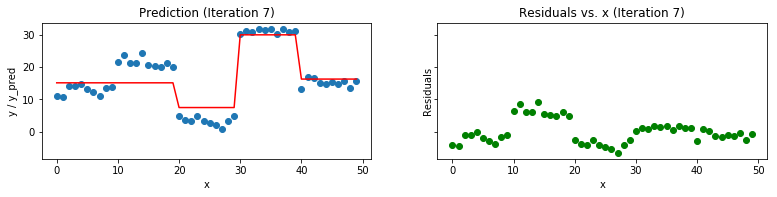

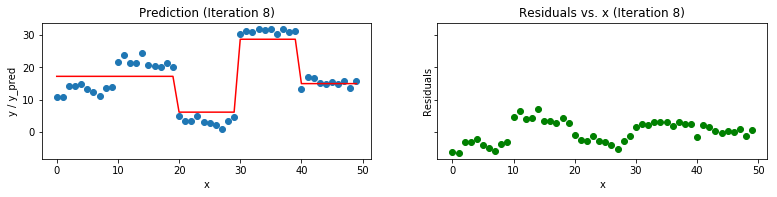

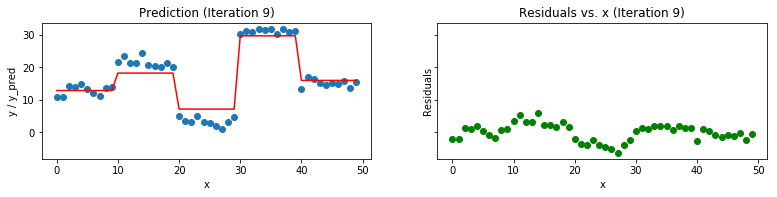

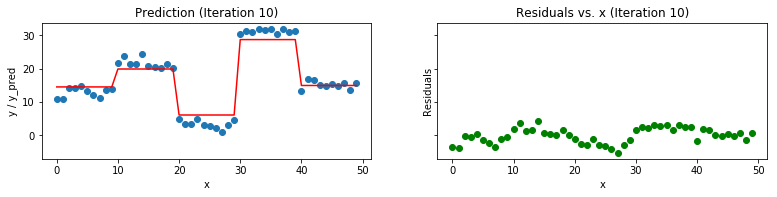

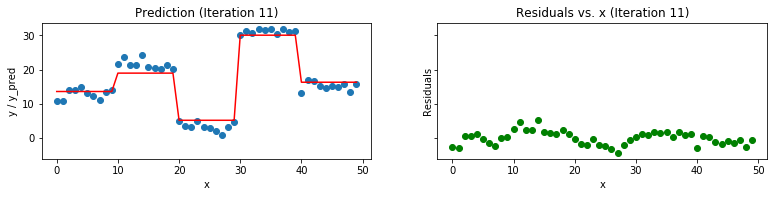

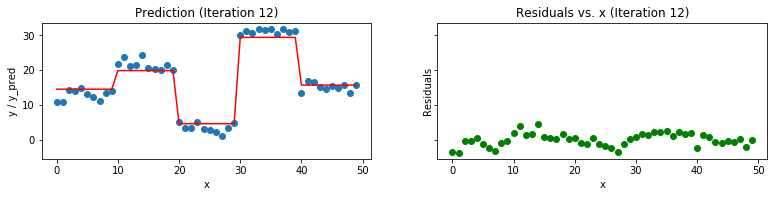

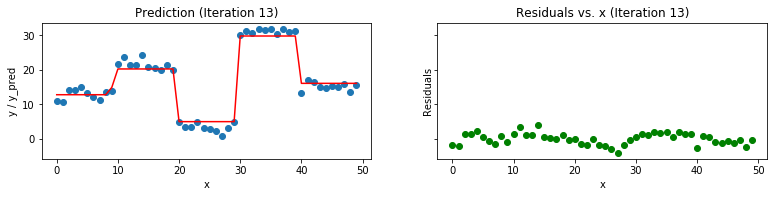

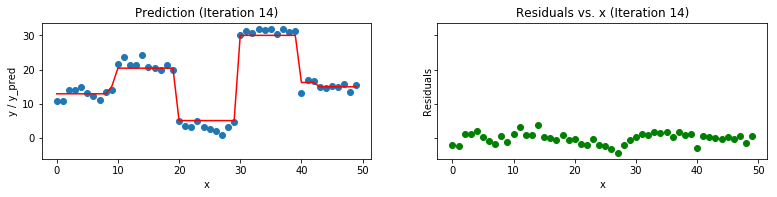

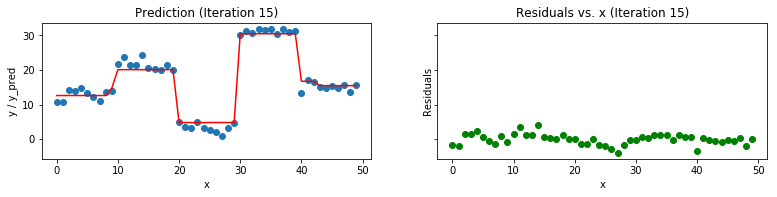

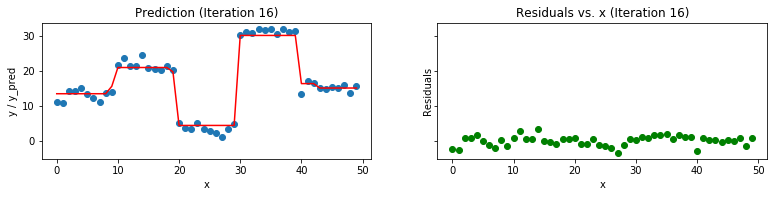

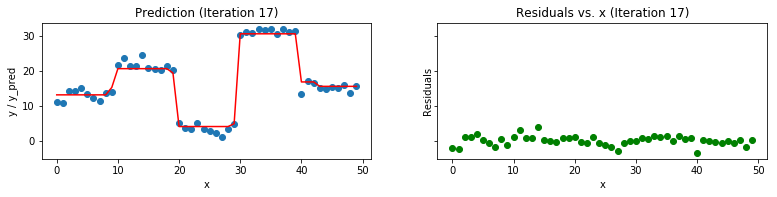

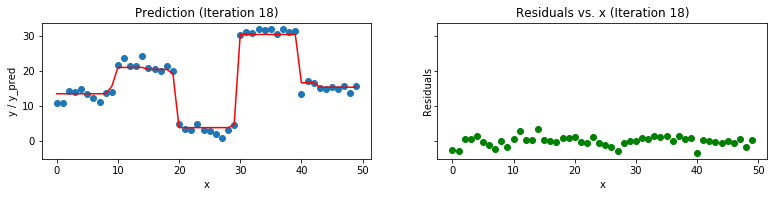

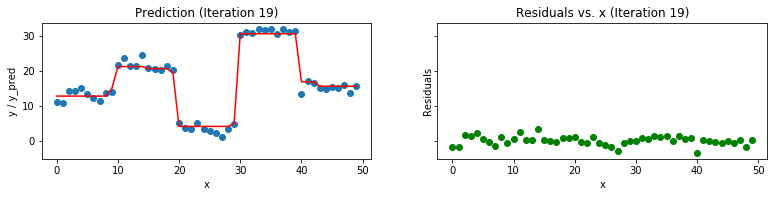

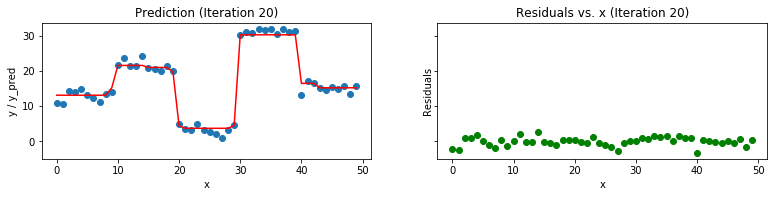

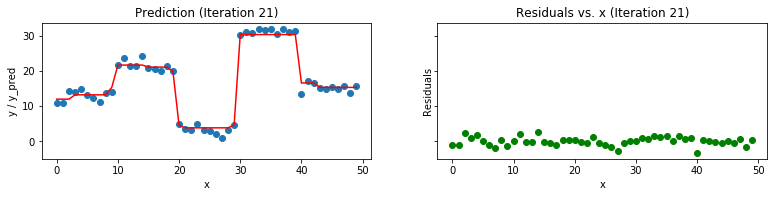

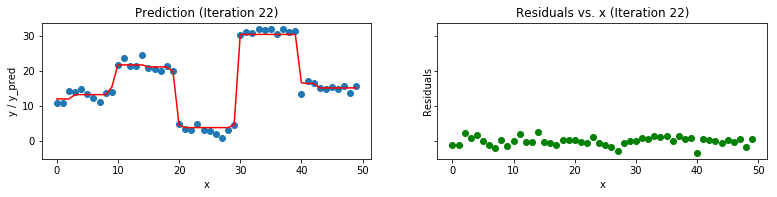

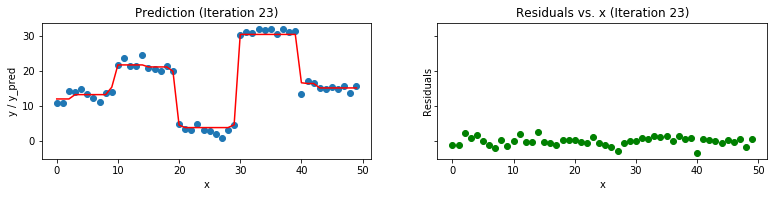

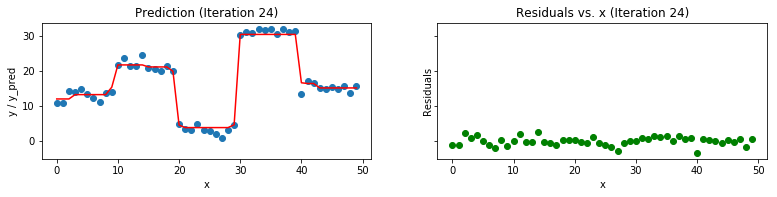

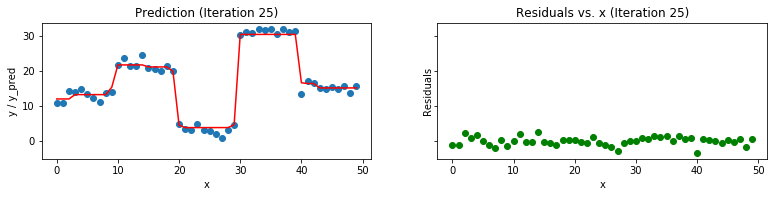

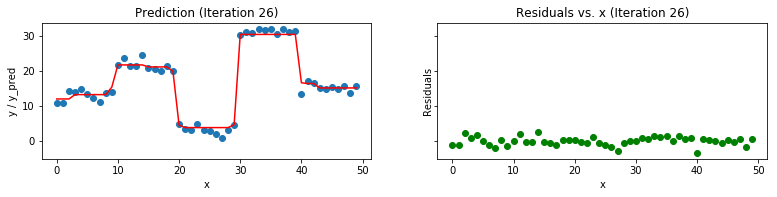

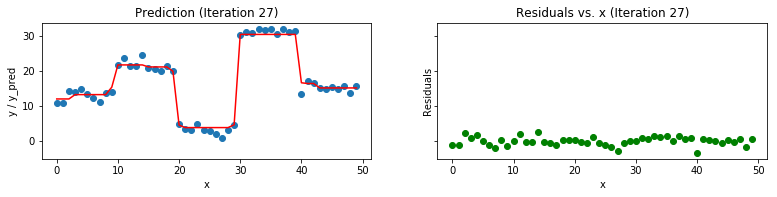

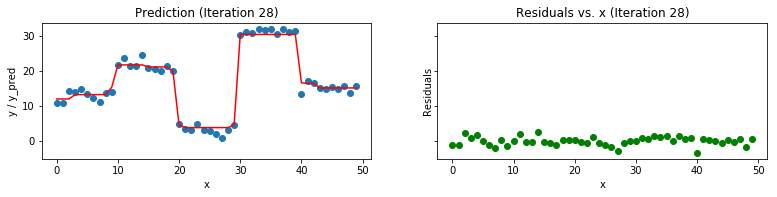

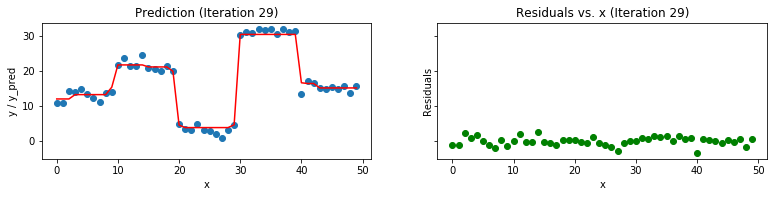

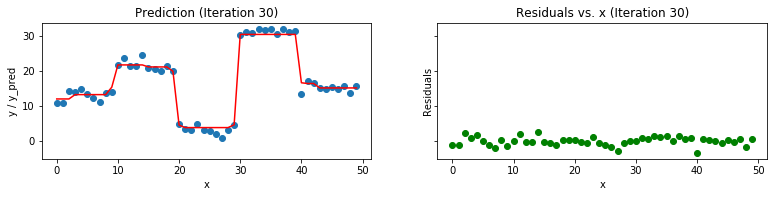

In [10]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(30): # like n_estimators
    ####
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    #### 
    
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    #print(ei)
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title('Prediction (Iteration ' + str(i+1) + ')')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title('Residuals vs. x (Iteration ' + str(i+1) + ')')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')

## Examples for ADABoost and XGBoost

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.datasets import load_iris, load_digits, load_boston
from sklearn.metrics import confusion_matrix, mean_squared_error

import xgboost as xgb

In [18]:
digits = load_digits()
X = digits['data']
y = digits['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

dt = DecisionTreeClassifier(max_depth=10, random_state=42).fit(X_train, y_train)

# AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),
                         random_state=42).fit(X_train, y_train)

print("Decision tree accuracy: %.2f" % dt.score(X_test, y_test))
print("AdaBoost accuracy: %.2f" % ada.score(X_test, y_test))

Decision tree accuracy: 0.81
AdaBoost accuracy: 0.96


In [20]:
iris = load_iris()
X = iris['data']
y = iris['target']
kf = KFold(n_splits=5, shuffle=True, random_state=13)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
[[9 0 0]
 [0 9 1]
 [0 2 9]]
[[12  0  0]
 [ 0 10  1]
 [ 0  0  7]]
[[10  0  0]
 [ 0 11  0]
 [ 0  0  9]]


C:\Users\mikhail\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\mikhail\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\mikhail\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\mikhail\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\